In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

#Data Preparation

#1- Data Loading

In [2]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-12-24 18:19:22--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  4.35MB/s    in 1.7s    

2023-12-24 18:19:25 (4.35 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [3]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


#2 - Data Preprocessing

In [4]:
text_dataset = tf.data.TextLineDataset("/content/dataset/fra.txt")


In [5]:
text_dataset

<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [6]:
# Setting up the configurations parameters
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 64
FRENCH_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300
BATCH_SIZE = 64

In [7]:
english_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [8]:
french_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [9]:
def selector(input_text):
  split_text = tf.strings.split(input_text, '\t')

  return {'input_1':split_text[0:1], 'input_2':'starttoken'+split_text[1:2]}, split_text[1:2]+ ' endtoken'

In [10]:
split_dataset = text_dataset.map(selector)

In [11]:
def separator(input_text):
  split_text = tf.strings.split(input_text, '\t')
  return split_text[0:1], 'starttoken'+split_text[1:2]+' endtoken'

In [12]:
init_dataset = text_dataset.map(separator)

In [13]:
for i in split_dataset.take(4):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttokenVa !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttokenMarche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttokenEn route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'startto

In [14]:
english_training_data = init_dataset.map(lambda x, y: x)
english_vectorize_layer.adapt(english_training_data)

In [15]:
print(len(english_vectorize_layer.get_vocabulary()))
print(len(french_vectorize_layer.get_vocabulary()))

16814
2


In [16]:
french_training_data = init_dataset.map(lambda x, y:y)
french_vectorize_layer.adapt(french_training_data)

In [17]:
def vectorizer(inputs, output):
  return {'input_1': english_vectorize_layer(inputs['input_1']),
          'input_2': french_vectorize_layer(inputs['input_2'])}, french_vectorize_layer(output)

In [18]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [19]:
dataset=split_dataset.map(vectorizer)

In [20]:
for i in split_dataset.take(4):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttokenVa !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttokenMarche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttokenEn route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'startto

In [21]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[1105,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[115,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 

In [22]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [23]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [25]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [26]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))


In [27]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# **Model Building**

In [28]:
NUM_UNITS=256

In [29]:
#Defining the encoder
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype='int64', name='input_1')
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM,)(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

#Defining the decoder
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH, ), dtype='int64', name='input_2')
x =Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

# Defining the output
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE, activation='softmax')(x)

seq2seq_gru =Model([input, shifted_target], target)
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

In [30]:
# Metrics

In [31]:
class BLEU(tf.keras.metrics.Metric):

  def __init__(self,name='bleu_score'):
    super(BLEU, self).__init__()
    self.bleu_score = 0

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred=tf.argmax(y_pred, -1)
    self.bleu_score = 0

    for i, j in zip(y_pred, y_pred):
      tf.autograph.experimental.set_loop_options()

      total_words = tf.math.count_nonzero(i)
      total_matches=0
      for word in i:
        if word==0:
          break
        for q in range(len(j)):
          if j[q]==0:
            break
          if word==j[q]:
            total_matches+=1
            j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
            break

    self.bleu_score+=total_matches/total_words


  def result(self):
    return self.bleu_score/BATCH_SIZE


In [32]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4)
)

In [33]:
checkpoint_filepath = '/content/drive/MyDrive/ML-with-tensorflow/Machine-translation/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)

In [34]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
   2812/Unknown - 360s 125ms/step - loss: 0.2847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2812/2812 [==============================] - 426s 149ms/step - loss: 0.2847 - val_loss: 0.1921
Epoch 2/20
2812/2812 [==============================] - 403s 143ms/step - loss: 0.0532 - val_loss: 0.0964
Epoch 3/20
2812/2812 [==============================] - 402s 143ms/step - loss: 0.0201 - val_loss: 0.0648
Epoch 4/20
2812/2812 [==============================] - 402s 143ms/step - loss: 0.0083 - val_loss: 0.0500
Epoch 5/20
2812/2812 [==============================] - 401s 142ms/step - loss: 0.0036 - val_loss: 0.0410
Epoch 6/20
2812/2812 [==============================] - 399s 142ms/step - loss: 0.0016 - val_loss: 0.0356
Epoch 7/20
2812/2812 [==============================] - 399s 142ms/step - loss: 8.6818e-04 - val_loss: 0.0318
Epoch 8/20
2812/2812 [==============================] - 401s 143ms/step - loss: 5.3349e-04 - val_loss: 0.0292
Epoch 9/20
2812/2812 [==============================] - 400s 142ms/step - loss: 3.6230e-04 - val_loss: 0.0272
Epoch 10/20
2812/2812 [======================

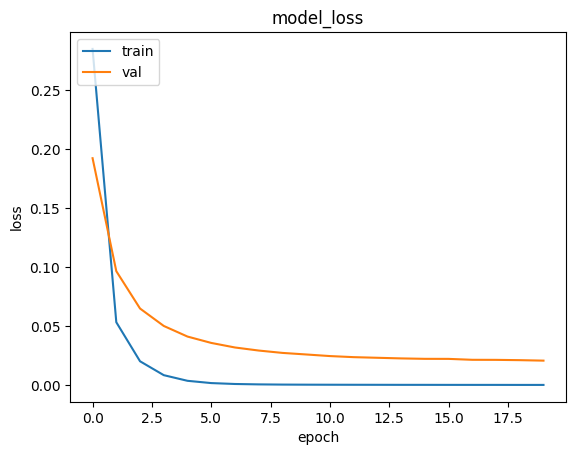

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: ignored

In [40]:
seq2seq_gru.metrics_names

['loss']

#Model Evaluation

In [41]:
seq2seq_gru.evaluate(val_dataset)

779/779 [==============================] - 61s 47ms/step - loss: 0.0206


0.0206457432359457

#Model Testing

In [42]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [43]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that is not true?')

1/1 [==============================] - 0s 67ms/step


In [ ]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}